## AI BOOTCAMP - Exercises Week 8 - Tree Based Methods

In [1]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier

### Question 1  
#### In the lab, we applied random forests to the `Boston` data using `max_features=6` and using `n_estimators=25` and `n_estimators=500`. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for max_features and n_estimators. Describe the results obtained.

In [4]:
boston_df = datasets.load_boston()
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']], columns= [c for c in boston_df['feature_names']] + ['MEDV'])

np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

display(boston_df.head())

# Create design and response matrix
f = 'MEDV ~ ' + ' + '.join(boston_df.columns.drop(['MEDV']))
y, X = pt.dmatrices(f, boston_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


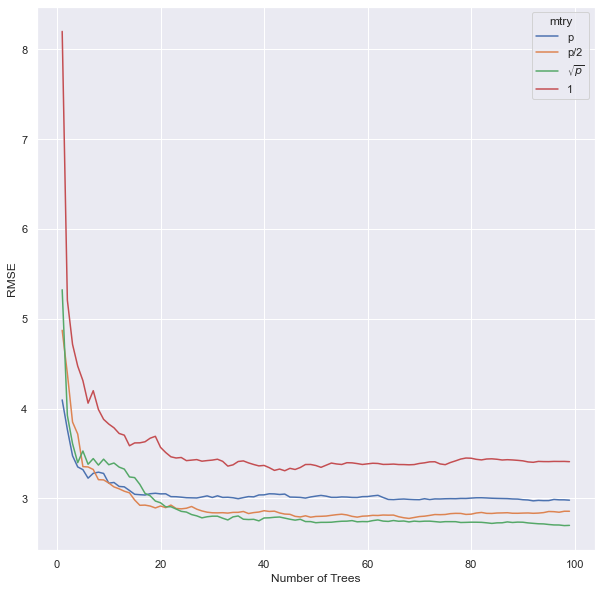

In [5]:
# Compare test RMSE of Random Forest for various numbers of features considered at each split (max_features)
# and increasing number of trees (n_estimators)

#set different parameters for the number of features
max_features = {'p': X.shape[1], # use all predictors
                'p/2': int(np.around(X.shape[1]/2)),
                '$\sqrt{p}$': int(np.around(np.sqrt(X.shape[1]))),
                '1': 1}          # use one predictor

results = []
for mtry in max_features:
    for tree_count in np.arange(1, 100):
        regr   = RandomForestRegressor(max_features=max_features[mtry], random_state=0, n_estimators=tree_count)
        regr.fit(X[train], y[train])
        y_hat = regr.predict(X[~train])
        
        mse = metrics.mean_squared_error(y[~train], y_hat)
        rmse = np.sqrt(mse)
        results+= [[tree_count, mtry, rmse]]

plt.figure(figsize=(10,10))
sns.lineplot(x='Number of Trees', y='RMSE', hue='mtry', 
             data=pd.DataFrame(results, columns=['Number of Trees', 'mtry', 'RMSE']));

The above shows the test RMSE for a 40% holdout set where training set contains 349 observations each with 14 predictors.

We find that the test RMSE decreases with increasing number of trees for all values of `max_features` (number of random features considered at each split)

The optimal value of $m$ is less than $p$ and greater than $1$. In this case $m=\sqrt{p}$ yields the best results for `n_estimators` although $p/2$ performs better for some lower tree counts.

Incredibly the model does not seem prone to overfitting with test RMSE continuing to decrees up to `max_features = 100`.

### Question 2
In the lab, a classification tree was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. Now we will seek to predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

#### (a) Split the data set into a training set and a test set.


In [8]:
carseats_df = pd.read_csv('Carseats.csv')

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0

# Create index for training set
np.random.seed(1)
train = np.random.random(len(carseats_df)) > 0.3

display(carseats_df.head())

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


#### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [12]:
# Use all features excpet response features
# No intercept
preds = carseats_df.columns.drop(['Sales'])

#preds_scaled = ['standardize({})'.format(p) for p in preds]
f = 'Sales ~ 0 +' + ' + '.join(preds)
y, X = pt.dmatrices(f, carseats_df)
y = y.flatten()

# Fit Sklearn's tree regressor
clf = tree.DecisionTreeRegressor(max_depth=5).fit(X[train], y[train])

# Measure test set MSE
y_hat = clf.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE: {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

Test MSE: 5.194
Test RMSE: 2.279


#### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

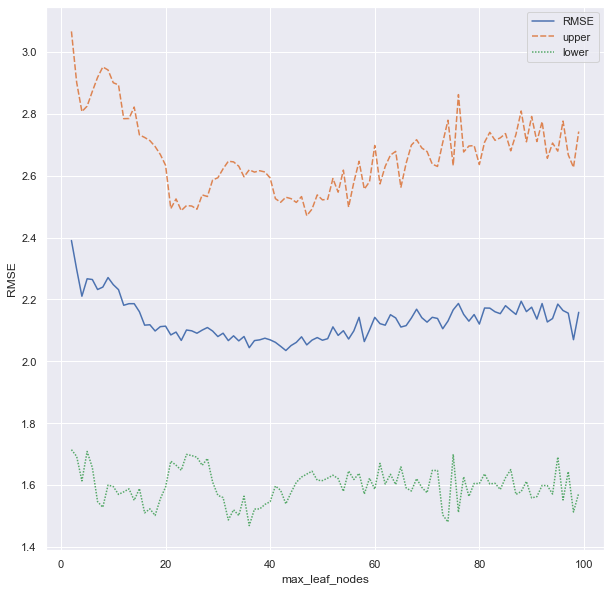

,RMSE,upper,lower
max_leaf_nodes,,,
43.0,2.034657,2.530301,1.539013


Test MSE : 5.307
Test RMSE: 2.304


In [11]:
# How about using CV to compare trees with different number of leaf nodes 
# as defined by the max_leaf_nodes parameter?

cv_folds = 10
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'RMSE', 'upper', 'lower']

results = []
for m in np.arange(2, 100):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(regr, X[train], y[train], cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();

# Show chosen model
chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(chosen)

# Use chosen model for test prediction
regr  = tree.DecisionTreeRegressor(max_leaf_nodes=int(chosen.index[0])).fit(X[train], y[train])
y_hat = regr.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

10-fold cross validation selects a pruned tree model that achieves test MSE of 5.307, not necessarily an improvement on the unpruned model (5.194). Interestingly select an improvement on the unpruned model wasn't achieved using this pruning method. We could try other parameters like `max_features` or `n_estimators`. I think it's more a shortcoming of python not expressly creating a mechanism for pruning individual trees. I'm also abandoning this part because I know bagging and random forests are about to kill this singular tree in terms of predicting `MEDV`.

#### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the `feature_importances_()` function to determine which variables are most important.

In [13]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

max_features = X.shape[1]
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(rmse, 3)))

Test MSE : 2.861
Test RMSE: 1.691


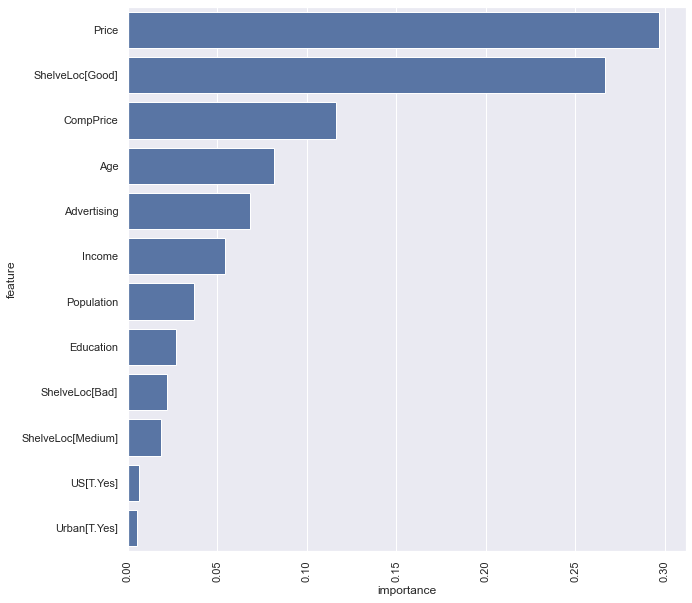

In [14]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

Bagging yields a significantly improved test MSE of 2.615 compared with 5.194 for the orignal tree and 5.307 from our "optimal pruned tree".

The bagging model indicates that instore `Shelve Location (Good)` and `Price` of the carseat are the most significant features affecting `Sales` revenue. This aligns with our observation when performing classification in the lab.

#### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the `feature_importances_()` function to determine which variables are most important. Describe the effect of *m*, the number of variables considered at each split, on the error rate obtained.

In [19]:
# Random Forest with 100 trees and 4 features considered at each split

max_features = 7
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 2.764
RMSE test: 1.662


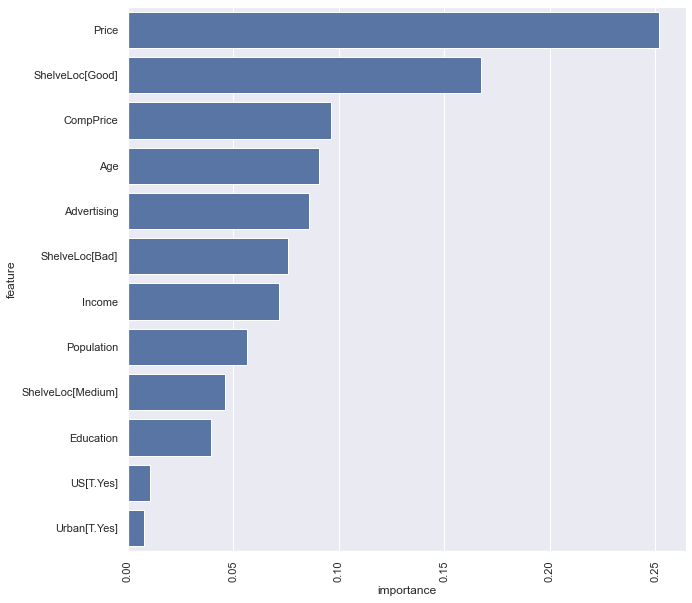

In [18]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

Random forest with 7 predictors (4 is worse) at each split yields a test MSE 2.764 similar to bagging (2.861). A similar feature importance is ascribed.

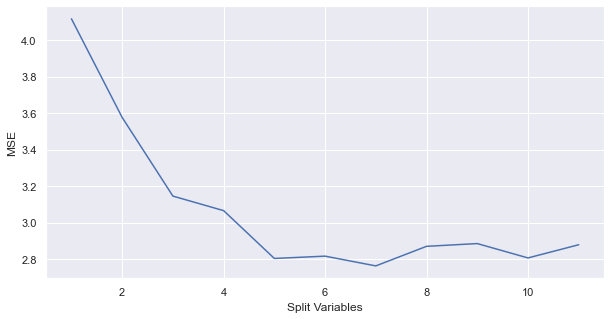

In [20]:
# Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

results = []
for max_features in np.arange(1, X.shape[1]):

    tree_count   = 100
    
    regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
    regr.fit(X[train], y[train])
    y_hat = regr.predict(X[~train])
    
    mse = metrics.mean_squared_error(y[~train], y_hat)
    rmse = np.sqrt(mse)
    
    results += [[max_features, mse]]

plt.figure(figsize=(10,5))
sns.lineplot(x='Split Variables', y='MSE', data=pd.DataFrame(results, columns=['Split Variables', 'MSE']));

The plot above shows how MSE is affected by the `max_features` argument. The lowest estimate is achieved at `max_features=7` which is how I cheated for the last question (we were supposed to use 4).